In [1]:
%matplotlib inline

from matplotlib_inline import backend_inline
import pywt
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from datetime import datetime
from torch.utils import data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.metrics import r2_score

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
plt.rcParams['font.sans-serif'] = ['SimHei']

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps')
# device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')


## 加载数据

In [6]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './datasets/NASA/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)

Load Dataset B0005.mat ...


C:\Users\Coyle\AppData\Local\Temp\ipykernel_14792\3199085973.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [3]:
len(Battery['B0006'][0]), len(Battery['B0006'][1])

(168, 168)

## 画出数据

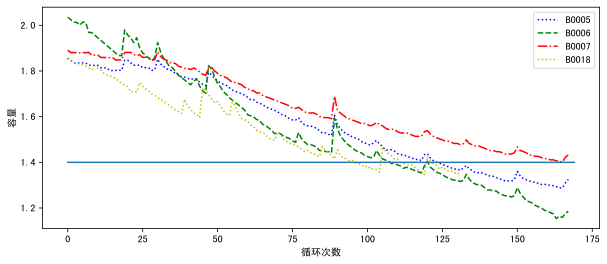

In [7]:
%matplotlib inline

def matplot_battery_list(battery_data_list):
    color_list = ['b:', 'g--', 'r-.', 'y:']
    # 1.创建画布
    plt.figure(figsize=(10, 4), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')

    # 2.绘制折线图
    for index, data in enumerate(battery_data_list):
        plt.plot([i for i in range(len(battery_data_list[index]))], battery_data_list[index], color_list[index])

    plt.plot([i for i in range(170)], [1.4] * 170)

    # 图例
    plt.legend([name for name in Battery_list])

Battery_data_list = [Battery['B0005'][1], Battery['B0006'][1], Battery['B0007'][1], Battery['B0018'][1]]
matplot_battery_list(Battery_data_list)

## 创建评估指标函数

In [5]:
threshold_xi = [0.7, 0.7, 0.75, 0.7]

# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    r2 = r2_score(y_test, y_predict)
    return mae, rmse, r2

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    return abs(true_re - pred_re) / true_re

# relative_error(Battery['B0006'][1], Battery['B0006'][1], 1.4)

## 小波降噪 level=2

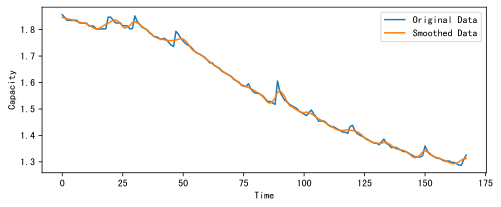

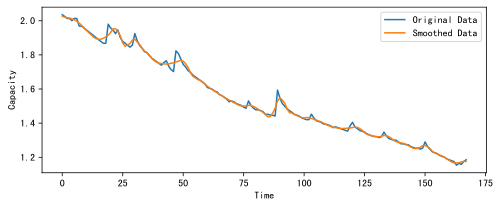

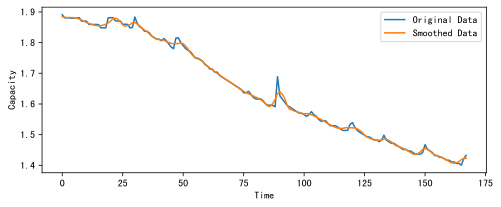

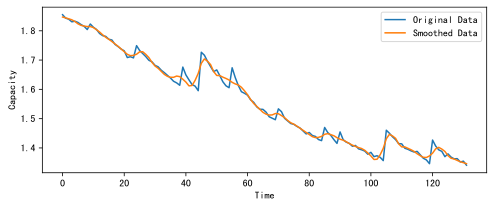

battery_index:0    , MAE:0.0056 , RMSE:0.0086 , RE:0.0080
battery_index:1    , MAE:0.0093 , RMSE:0.0152 , RE:0.0092
battery_index:2    , MAE:0.0047 , RMSE:0.0076 , RE:0.0000
battery_index:3    , MAE:0.0093 , RMSE:0.0143 , RE:0.0103


In [7]:
# 小波降噪函数
def wavelet_smoothing(data, wavelet='db4', level=2):
    # 小波分解
    coeffs = pywt.wavedec(data, wavelet, level=level)
    
    # 阈值处理（可根据需求调整阈值）
    threshold = 1.5
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold, mode='soft')
    
    # 小波重构
    smoothed_data = pywt.waverec(coeffs, wavelet)
    
    return smoothed_data

wd_battery_data_list = []
for b_data in Battery_data_list:
    # 原始的时间序列数据
    original_data = b_data

    smoothed_data = wavelet_smoothing(original_data)
    wd_battery_data_list.append(smoothed_data)

    # 可视化原始数据和平滑后的数据
    fig = plt.figure(figsize=(8, 3), dpi=80)
    plt.plot(original_data, label='Original Data')
    plt.plot(smoothed_data, label='Smoothed Data')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Capacity')
    display(fig)
    plt.close()

# 检查下 小波降噪后的数据的指标评分
rate_i = 0
for o_data, k_data in zip(Battery_data_list, wd_battery_data_list):
    mae, rmse, r2 = evaluation(o_data, k_data)
    re = relative_error(o_data, k_data, threshold=2 * 0.7)
    battery_index = rate_i
    rate_i+=1
    print('battery_index:{:<4d} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f}'.format(battery_index, mae, rmse, re))

## 小波降噪 level=1

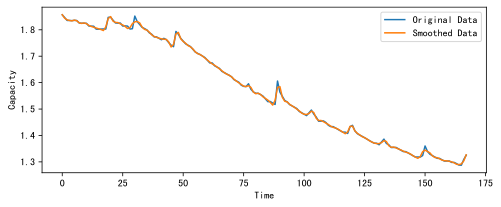

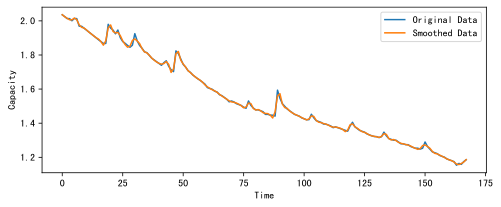

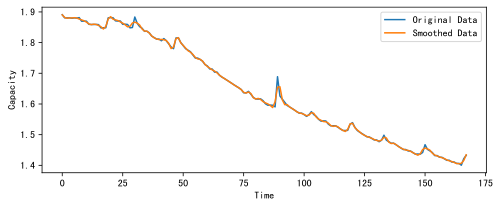

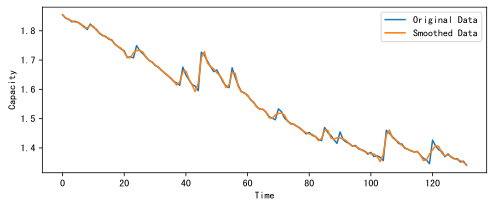

battery_index:0    , MAE:0.0030 , RMSE:0.0049 , RE:0.0000
battery_index:1    , MAE:0.0047 , RMSE:0.0077 , RE:0.0000
battery_index:2    , MAE:0.0026 , RMSE:0.0049 , RE:0.0000
battery_index:3    , MAE:0.0054 , RMSE:0.0084 , RE:0.0000


In [13]:
# 小波降噪函数
def wavelet_smoothing(data, wavelet='db4', level=1):
    # 小波分解
    coeffs = pywt.wavedec(data, wavelet, level=level)
    
    # 阈值处理（可根据需求调整阈值）
    threshold = 2.5
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]), mode='soft')
    
    # 小波重构
    smoothed_data = pywt.waverec(coeffs, wavelet)
    
    return smoothed_data

wd_battery_data_list = []
for b_data in Battery_data_list:
    # 原始的时间序列数据
    original_data = b_data

    smoothed_data = wavelet_smoothing(original_data)
    wd_battery_data_list.append(smoothed_data)

    # 可视化原始数据和平滑后的数据
    fig = plt.figure(figsize=(8, 3), dpi=80)
    plt.plot(original_data, label='Original Data')
    plt.plot(smoothed_data, label='Smoothed Data')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Capacity')
    display(fig)
    plt.close()

# 检查下 小波降噪后的数据的指标评分
rate_i = 0
for o_data, k_data in zip(Battery_data_list, wd_battery_data_list):
    mae, rmse, r2 = evaluation(o_data, k_data)
    re = relative_error(o_data, k_data, threshold=2 * 0.7)
    battery_index = rate_i
    rate_i+=1
    print('battery_index:{:<4d} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f}'.format(battery_index, mae, rmse, re))

## 构建训练序列数据

In [9]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size
# train_y 的维度是 window_size
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    x, y = [], []
    for i in range(len(text) - window_size):
        sequence = text[i:i + window_size]
        target = text[i + 1:i + window_size + 1]
        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)

def get_train_test_data(data_list, battery_i, window_size=16):
    data_sequence = Battery[Battery_list[battery_i]][1]
    train_data, test_data = data_sequence[:window_size], data_sequence[window_size:]
    
    train_x, train_y = None, None
    for i, v in enumerate(data_list):
        print(len(v))
        if i != battery_i:
            data_x, data_y = build_seq(text=v, window_size=window_size)
            if train_x is None:
                train_x = data_x
                train_y = data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [11]:
train_x, train_y, train_data, test_data = get_train_test_data(Battery_data_list, 1, window_size=16)

len(train_x),len(train_y), len(train_data),len(test_data)

168
168
168
132


(420, 420, 16, 152)

## 检验 train_iter 数据是否正确

In [10]:
# train_x, train_y, train_data, test_data = get_train_test_data(Kalman_battery_data_list, 0, window_size=16)
train_x, train_y, train_data, test_data = get_train_test_data(Battery_data_list, 0, window_size=16)
print()
train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
train_iter = load_capacity_data((train_x, train_y), 2, is_train=False)

# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for x, y in train_iter:
        print(x.shape)
        print(y.shape)
        
        print(x)
        print(y)
        break



validate_train_iter(train_iter)

168
168
168
132
torch.Size([2, 16])
torch.Size([2, 16])
tensor([[2.0353, 2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682,
         1.9572, 1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892],
        [2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
         1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783]])
tensor([[2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
         1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783],
        [2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572, 1.9456,
         1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783, 1.8676]])


## 绘制 out 和  tgt_y的对比图

In [16]:
# 绘制 out  tgt_y的对比图
def matlab_make(out, tgt_y):
    color_list = ['b:', 'g:']
    # 1.创建画布
    fig = plt.figure(figsize=(7, 2), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')
    
    data_list = [
        {
            'name': 'out',
            'x': [i for i in range(len(out))],
            'y': out
        },
        {
            'name': 'tgt_y',
            'x': [i for i in range(len(tgt_y))],
            'y': tgt_y
        }
    ]

    # 2.绘制折线图
    for data,color in zip(data_list, color_list):
        plt.plot(data['x'], data['y'], color)


    # 图例
    plt.legend([data['name'] for data in data_list])
    
    display(fig)
    plt.close() 

# out_t = [1,2,3,4,5,6,7,8,9,10]
# tgt_y_t = [11,21,31,41,51,61,71,81,91,110]

# matlab_make(out_t, tgt_y_t)

## 2维数据的残差1D卷积网络

In [17]:
# 残差网络
class Residual1D(nn.Module):
    def __init__(self, input_channels, num_channels, kernel_size, strides=1):
        super().__init__()
        
        self.conv1 = nn.Conv1d(input_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        
        X = torch.cat([X, X], dim=1)
        
        Y = X + Y
        return F.relu(Y)


    
blk = Residual1D(32, 64, 3)
X = torch.rand(50, 32, 16)
Y = blk(X)
Y.shape

torch.Size([50, 64, 16])

## 随机种子

In [18]:
# 设置随机种子
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed)  # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## 搭建模型

In [25]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 初始化Shape为(max_len, d_model)的PE (positional encoding)
        pe = torch.zeros(max_len, d_model)
        # 初始化一个tensor [[0, 1, 2, 3, ...]]
        position = torch.arange(0, max_len).unsqueeze(1)
        # 这里就是sin和cos括号中的内容，通过e和ln进行了变换
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        # 计算PE(pos, 2i)
        pe[:, 0::2] = torch.sin(position * div_term)
        # 计算PE(pos, 2i+1)
        pe[:, 1::2] = torch.cos(position * div_term)
        # 为了方便计算，在最外面在unsqueeze出一个batch
        pe = pe.unsqueeze(0)
        # 如果一个参数不参与梯度下降，但又希望保存model的时候将其保存下来
        # 这个时候就可以用register_buffer
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x 为embedding后的inputs，例如(1,7, 128)，batch size为1,7个单词，单词维度为128
        """
        # 将x和positional encoding相加。
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)


class Net(nn.Module):

    def __init__(self, d_model=16, nhead=16, num_encoder_layers=2, dim_feedforward=32, kernel_size=3, dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        
        # 残差卷积网络层
        self.rcnn = Residual1D(d_model, d_model * 2, kernel_size=kernel_size)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(d_model * 2, 1)

    def forward(self, x):
        

        # 对 x 进行编码
        # x = x.reshape(x.shape[0], x.shape[1], 1)
        x = x.reshape(x.shape[0], 1, x.shape[1])
        
        # x = self.linear_embedding(x)
        
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
    
        
        out = self.transformerEncoder(x)
        #print(out.shape)
        
        
        # 残差卷积网络层
        out = out.permute(0, 2, 1)
        out = self.rcnn(out).permute(0, 2, 1) # 输出 out shape: (batch_size, seq_len, d_model * 2)

        out = self.predictor(out)
    
        return out

## 测试模型的输出形状

In [21]:
# 测试模型的输出形状
net = Net(d_model=16).to(device)

# src = torch.LongTensor([[0, 3, 4, 5, 6, 1, 2, 2]])
x = torch.ones((50, 16), dtype=torch.float32).to(device)

out = net(x)
print(out.size())

torch.Size([50, 1, 1])


## 一个批次的训练函数

In [20]:
def train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity): 
    # 将模型设置为训练模式
    net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for x, y in train_iter:
        # 计算梯度并更新参数
        x = torch.reshape(x / Rated_Capacity, (-1, x.shape[-1])).type(torch.float32)
        # y = torch.reshape(y / Rated_Capacity, (-1, y.shape[-1])).type(torch.float32)
        y = torch.reshape(y[:, -1] / Rated_Capacity, (-1, 1)).type(torch.float32)
        x, y = x.to(device), y.to(device)
 
        out = net(x)
        
        l = loss(out.reshape(-1), y.reshape(-1))
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

## 总的训练函数

In [21]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_y, pre_list, threshold=Rated_Capacity * 0.7)

        if (len(rmse_epoch_list) == 0 or (rmse_epoch_list[-1] < rmse)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]

## 预测函数

In [22]:
def predict(net, train_data, test_data, Rated_Capacity):
    net = net.eval()
    
    x = train_data.copy()
    x = np.array(x)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    x = torch.reshape(x / Rated_Capacity, (1, -1)) # shape: (batch_size, input_size)
    
    pre_list = []
    while len(pre_list) < len(test_data):
        
        
        out = net(x)
        x = torch.cat([x[:, 1:], out[:, -1]], dim=1)
        
        pred = out.reshape(-1)
        
        
        
        pred_next_point = pred.cpu().data.numpy()[-1] * Rated_Capacity
        
        
        pre_list.append(pred_next_point)
        
        
    return pre_list
        
    
# x = train_data.copy()
# pred_list = predict(net, train_data, test_data, 2)
# print((pred_list))
# print((test_data))

# print(len(pred_list))
# print(len(test_data))
# matlab_make(pred_list, test_data)

## 以rmse评价指标为判断函数 开始训练

In [ ]:
def train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity): 
    # 将模型设置为训练模式
    net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for x, y in train_iter:
        # 计算梯度并更新参数
        x = torch.reshape(x / Rated_Capacity, (-1, x.shape[-1])).type(torch.float32)
        y = torch.reshape(y / Rated_Capacity, (-1, y.shape[-1])).type(torch.float32)
        
        x, y = x.to(device), y.to(device)
 
        out = net(x)
        
        l = loss(out.reshape(-1), y.reshape(-1))
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

class Net(nn.Module):

    def __init__(self, d_model=16, nhead=16, num_encoder_layers=2, dim_feedforward=32, kernel_size=3, dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        
        # 残差卷积网络层
        self.rcnn = Residual1D(d_model, d_model * 2, kernel_size=kernel_size)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        
        self.dense = nn.Linear(d_model * 2, d_model)
        
        self.predictor = nn.Linear(d_model, 1)

    def forward(self, x):

        # 对 x 进行编码
        x = x.reshape(x.shape[0], x.shape[1], 1)
        
        x = self.linear_embedding(x)
        
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
        
        out = self.transformerEncoder(x)
        #print(out.shape)
        
        # 残差卷积网络层
        out = out.permute(0, 2, 1)
        out = self.rcnn(out).permute(0, 2, 1) # 输出 out shape: (batch_size, seq_len, d_model * 2)

        out = self.dense(out)
        out = self.predictor(out)
    
        return out

def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_y, pre_list, threshold=Rated_Capacity * threshold_xi[i])
        currentSum = 0
        lastSum = 0
        
        if (len(re_epoch_list) > 0):
            currentSum = rmse
            lastSum = rmse_epoch_list[-1]

        if (len(re_epoch_list) == 0 or (currentSum < lastSum)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f} , currentSum:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2, currentSum))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]


# 电池额定容量
Rated_Capacity = 2.0

# 模型参数
d_model = 16
nhead = 4
num_encoder_layers = 3
dim_feedforward = 64
kernel_size = 5

# 训练参数
batch_size = 50
lr = 0.0001
weight_decay = 0.0001
num_epochs = 1000
window_size = 32

# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], []
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
    # for i in range(1):
        train_x, train_y, train_data, test_data = get_train_test_data(wd_battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, 
                  dim_feedforward=dim_feedforward, kernel_size=kernel_size)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're min: {np.array(re_s).min()}')
    print(f'mae min: {np.array(mae_s).min()}')
    print(f'rmse min: {np.array(rmse_s).min()}')
    print(f'r2 max: {np.array(r2_s).max()}')
    print('---------------------------------')
    
    re_seed_all.append(np.array(re_s).min())
    mae_seed_all.append(np.array(mae_s).min())
    rmse_seed_all.append(np.array(rmse_s).min())
    r2_seed_all.append(np.array(r2_s).max())

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 max: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0005, epoch:1    , loss:0.4196227789 , MAE:1.0446 , RMSE:1.0579 , RE:0.9892 , R2:-41.9491 , currentSum:0.0000
seed: 0, 测试集: B0005, epoch:2    , loss:0.3435829580 , MAE:0.9789 , RMSE:0.9921 , RE:0.9892 , R2:-36.7737 , currentSum:0.9921
seed: 0, 测试集: B0005, epoch:3    , loss:0.2756756842 , MAE:0.9492 , RMSE:0.9616 , RE:0.9892 , R2:-34.4851 , currentSum:0.9616
seed: 0, 测试集: B0005, epoch:4    , loss:0.2279706448 , MAE:0.9416 , RMSE:0.9539 , RE:0.9892 , R2:-33.9170 , currentSum:0.9539
seed: 0, 测试集: B0005, epoch:5    , loss:0.1411545277 , MAE:0.8952 , RMSE:0.9091 , RE:0.9892 , R2:-30.7173 , currentSum:0.9091
seed: 0, 测试集: B0005, epoch:6    , loss:0.1368009746 , MAE:0.8477 , RMSE:0.8617 , RE:0.9892 , R2:-27.4976 , currentSum:0.8617
seed: 0, 测试集: B0005, epoch:7    , loss:0.0785506368 , MAE:0.8051 , RMSE:0.8172 , RE:0.9892 , R2

seed: 0, 测试集: B0006, epoch:30   , loss:0.0084914202 , MAE:0.1464 , RMSE:0.1762 , RE:0.7662 , R2:0.0771 , currentSum:0.1762
seed: 0, 测试集: B0006, epoch:32   , loss:0.0085651986 , MAE:0.1456 , RMSE:0.1752 , RE:0.7662 , R2:0.0874 , currentSum:0.1752
seed: 0, 测试集: B0006, epoch:33   , loss:0.0079739252 , MAE:0.1444 , RMSE:0.1742 , RE:0.7662 , R2:0.0983 , currentSum:0.1742
seed: 0, 测试集: B0006, epoch:34   , loss:0.0073572360 , MAE:0.1429 , RMSE:0.1731 , RE:0.7662 , R2:0.1090 , currentSum:0.1731
seed: 0, 测试集: B0006, epoch:35   , loss:0.0094890194 , MAE:0.1424 , RMSE:0.1726 , RE:0.7662 , R2:0.1147 , currentSum:0.1726
seed: 0, 测试集: B0006, epoch:36   , loss:0.0071226009 , MAE:0.1423 , RMSE:0.1722 , RE:0.7662 , R2:0.1182 , currentSum:0.1722
seed: 0, 测试集: B0006, epoch:37   , loss:0.0074690217 , MAE:0.1424 , RMSE:0.1717 , RE:0.7662 , R2:0.1233 , currentSum:0.1717
seed: 0, 测试集: B0006, epoch:39   , loss:0.0068678549 , MAE:0.1423 , RMSE:0.1711 , RE:0.7662 , R2:0.1303 , currentSum:0.1711
seed: 0, 测试集: B0

seed: 0, 测试集: B0007, epoch:24   , loss:0.0120440563 , MAE:0.1244 , RMSE:0.1549 , RE:0.7340 , R2:-0.3944 , currentSum:0.1549
seed: 0, 测试集: B0007, epoch:25   , loss:0.0120428260 , MAE:0.1231 , RMSE:0.1533 , RE:0.7234 , R2:-0.3648 , currentSum:0.1533
seed: 0, 测试集: B0007, epoch:27   , loss:0.0104526877 , MAE:0.1225 , RMSE:0.1522 , RE:0.7128 , R2:-0.3461 , currentSum:0.1522
seed: 0, 测试集: B0007, epoch:30   , loss:0.0096482001 , MAE:0.1185 , RMSE:0.1473 , RE:0.6915 , R2:-0.2604 , currentSum:0.1473
seed: 0, 测试集: B0007, epoch:43   , loss:0.0082226619 , MAE:0.1146 , RMSE:0.1418 , RE:0.6596 , R2:-0.1679 , currentSum:0.1418
seed: 0, 测试集: B0007, epoch:45   , loss:0.0084431907 , MAE:0.1144 , RMSE:0.1414 , RE:0.6596 , R2:-0.1620 , currentSum:0.1414
seed: 0, 测试集: B0007, epoch:46   , loss:0.0067070839 , MAE:0.1098 , RMSE:0.1354 , RE:0.5957 , R2:-0.0644 , currentSum:0.1354
seed: 0, 测试集: B0007, epoch:77   , loss:0.0047525940 , MAE:0.1058 , RMSE:0.1279 , RE:0.5638 , R2:0.0499 , currentSum:0.1279
seed: 0, 